In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.linear_model import SGDClassifier

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder

In [3]:
import pandas as pd
import pyodbc
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:

driver= '{ODBC Driver 13 for SQL Server}'
cnxn = pyodbc.connect('DRIVER='+driver+';PORT=1433;SERVER='+\
                      server+';PORT=1443;DATABASE='+database+';UID='+username+';PWD='+ password)
#cursor = cnxn.cursor()

In [5]:
data = pd.read_sql_query("""
SELECT [user_id]
, a.product_id
, add_to_cart_order,order_dow
, order_hour_of_day
, convert(float,days_since_prior_order) as days_since_prior_order
, department, aisle,reordered
, case when f.[order_id] is not null then 'Train' else 'Test' end as [label]
FROM [dbo].[order_products__prior] a (nolock)
left join dbo.orders b (nolock) on a.[order_id]=b.[order_id]
left join dbo.[products] c (nolock) on a.product_id = c.product_id
left join dbo.[departments] d (nolock) on c.department_id=d.department_id
left join dbo.[aisles] e (nolock) on c.aisle_id = e.aisle_id
left join dbo.[order_products__prior_train] f (nolock) on a.[order_id]=f.[order_id]
""",cnxn, coerce_float = True)
data['target'] = data.reordered.astype(int)

In [6]:
data['add_to_cart_order'] = data.add_to_cart_order.astype(int)
data['order_dow'] = data.order_dow.astype(int)
data['order_hour_of_day'] = data.order_hour_of_day.astype(int)
data['days_since_prior_order'] = data.days_since_prior_order.astype(int)
data['product_id'] = data.product_id.astype(int)

In [7]:
del data['reordered']

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 10 columns):
user_id                   object
product_id                int32
add_to_cart_order         int32
order_dow                 int32
order_hour_of_day         int32
days_since_prior_order    int32
department                object
aisle                     object
label                     object
target                    int32
dtypes: int32(6), object(4)
memory usage: 1.7+ GB


In [9]:
data.shape

(32434489, 10)

In [10]:
data.head()

,user_id,product_id,add_to_cart_order,order_dow,order_hour_of_day,days_since_prior_order,department,aisle,label,target
0,193700,32747,1,6,16,6,dairy eggs,milk,Train,1
1,193700,19508,2,6,16,6,bakery,tortillas flat bread,Train,0
2,193700,26209,3,6,16,6,produce,fresh fruits,Train,1
3,193700,42736,4,6,16,6,dairy eggs,butter,Train,1
4,193700,34243,5,6,16,6,produce,fresh vegetables,Train,0


In [11]:
encoder = OneHotEncoder()
label_encoder = LabelEncoder()
data_label_encoded = label_encoder.fit_transform(data['product_id'])
data['product_id2'] = data_label_encoded

In [12]:
# Split to train and test

In [13]:
#data_feature_one_hot_encoded = encoder.fit_transform(data[data.label == 'Train'][['product_id2']].as_matrix())
data_feature_one_hot_encoded = encoder.fit_transform(data[['product_id2']].as_matrix())

In [14]:
transformer1 = LabelBinarizer()
#did = pd.DataFrame(transformer1.fit_transform(data[data.label == 'Train']['department']), columns=transformer1.classes_)
did = pd.DataFrame(transformer1.fit_transform(data['department']), columns=transformer1.classes_)

In [15]:
transformer2 = LabelBinarizer()
# aid = pd.DataFrame(transformer2.fit_transform(data[data.label == 'Train']['aisle']), columns=transformer2.classes_)
aid = pd.DataFrame(transformer2.fit_transform(data['aisle']), columns=transformer2.classes_)

In [16]:
data.head()

,user_id,product_id,add_to_cart_order,order_dow,order_hour_of_day,days_since_prior_order,department,aisle,label,target,product_id2
0,193700,32747,1,6,16,6,dairy eggs,milk,Train,1,32741
1,193700,19508,2,6,16,6,bakery,tortillas flat bread,Train,0,19504
2,193700,26209,3,6,16,6,produce,fresh fruits,Train,1,26204
3,193700,42736,4,6,16,6,dairy eggs,butter,Train,1,42728
4,193700,34243,5,6,16,6,produce,fresh vegetables,Train,0,34237


In [17]:
# del data['user_id']
# del data['product_id']
# del data['department']
# del data['aisle']
# del data['product_id2']

In [18]:
data.shape

(32434489, 11)

In [19]:
# target = data[data.label == 'Train']['target'].as_matrix()
target = data['target'].as_matrix()

In [20]:
# data2 = data[data.label == 'Train'].drop(columns=['target','label']).as_matrix()
data2 = data.drop(columns=['product_id2','aisle','department','product_id','user_id','target','label']).as_matrix()

In [21]:
did2 = did.as_matrix() 
aid2 = aid.as_matrix() 

In [22]:
print(data2.shape ,
      did2.shape,aid2.shape,data_feature_one_hot_encoded.shape)

(32434489, 4) (32434489, 21) (32434489, 134) (32434489, 49677)


In [23]:
from scipy import sparse

In [24]:
### sparse.hstack because this is a sparsse matrix also needed to clear strings. numerics only
#fin = np.hstack( (data2, data_feature_one_hot_encoded ))
fin = sparse.hstack( (data2, data_feature_one_hot_encoded ))
fin = sparse.hstack( (fin, did2))
fin = sparse.hstack( (fin, aid2))

In [25]:
fin.shape

(32434489, 49836)

In [26]:
target

array([1, 0, 1, ..., 1, 1, 1])

In [27]:
data.head()

,user_id,product_id,add_to_cart_order,order_dow,order_hour_of_day,days_since_prior_order,department,aisle,label,target,product_id2
0,193700,32747,1,6,16,6,dairy eggs,milk,Train,1,32741
1,193700,19508,2,6,16,6,bakery,tortillas flat bread,Train,0,19504
2,193700,26209,3,6,16,6,produce,fresh fruits,Train,1,26204
3,193700,42736,4,6,16,6,dairy eggs,butter,Train,1,42728
4,193700,34243,5,6,16,6,produce,fresh vegetables,Train,0,34237


In [28]:
## new
TrainRows = np.where(data['label']=="Train")[0]
TestRows = np.where(data['label']=="Test")[0]

In [29]:
Trainfin = fin.tocsr()[TrainRows,:]
Testfin = fin.tocsr()[TestRows,:]

In [30]:
Train_target = target[TrainRows]
Test_target = target[TestRows]

In [31]:
print(Test_target.shape, Testfin.shape)

(6819727,) (6819727, 49836)


In [32]:
from sklearn.linear_model import SGDClassifier

#logreg = LogisticRegression()
clf = SGDClassifier(loss='log' , penalty = 'l2')
clf.fit(Trainfin, Train_target)
scores = cross_val_score(clf, Trainfin, Train_target, cv=5)
scores                                              

C:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\stochas

array([ 0.63844388,  0.63642961,  0.6339751 ,  0.63239652,  0.63879088])

In [33]:
np.mean(scores)

0.63600719761288027

In [34]:
data3 = pd.read_sql_query("""select b.[user_id]
, a.[order_id]
, a.[product_id]
, a.[reordered]
, isnull(c.[freq_product_laplace],0.0) as freq_product_laplace
, isnull(c.[freq_product], 0.0) as freq_product
, case when f.[order_id] is not null then 'Train' else 'Test' end as [label]
from [dbo].[order_products__prior] a
left join dbo.orders b on a.[order_id]=b.[order_id]
left join [dbo].[frequency_probability] c on b.[user_id]=c.[user_id] and a.[product_id]=c.[product_id]
left join dbo.[order_products__prior_train] f (nolock) on a.[order_id]=f.[order_id]
""",cnxn, coerce_float = True)

data3['target'] = data3.reordered.astype(int)

In [35]:
predicts =clf.predict_proba(Testfin)
# predicts =clf.predict_proba(Trainfin)

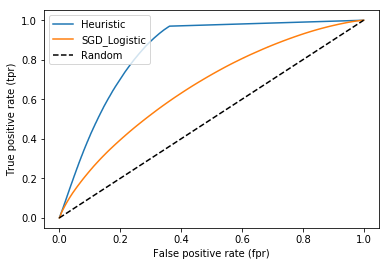

In [36]:
# Get the probability of Y_test records being = 1

# Use the metrics.roc_curve function to get the true positive rate (tpr) and false positive rate (fpr)
fpr, tpr, thresholds = metrics.roc_curve(data3[data3.label == 'Test']['target'],
                                         data3[data3.label == 'Test']['freq_product_laplace'])
fprSGD, tprSGD, thresholdsSGD = metrics.roc_curve(Test_target, predicts[:,1])

# Plot the ROC curve
plt.plot(fpr, tpr, label="Heuristic" )#, label="C=%s" % c)
plt.plot(fprSGD, tprSGD, label="SGD_Logistic" )
    
plt.xlabel("False positive rate (fpr)")
plt.ylabel("True positive rate (tpr)")
plt.plot([0,1], [0,1], 'k--', label="Random")
plt.legend(loc=2)
plt.show()

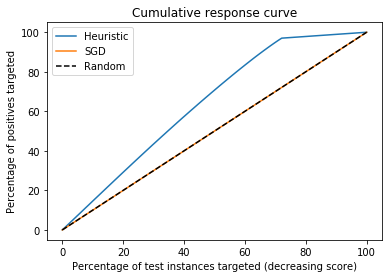

In [37]:
# Get the predicted value and the probability of Y_test records being = 1
Y_test_predicted = np.array([ 1 if p >= 0.0122 else 0 for p in data3[data3.label == 'Test']['freq_product_laplace'] ])
Y_test_probability = np.array(data3[data3.label == 'Test']['freq_product_laplace'])
#Y_test_probability_1 = 
Y_test =np.array(data3[data3.label == 'Test']['target'])

# Sort these predictions, probabilities, and the true value in descending order of probability
order = np.argsort(Y_test_probability)[::-1]
Y_test_predicted_sorted = Y_test_predicted[order]
Y_test_sorted = np.array(Y_test)[order]

#SGD
Y_test_predictedSGD = np.array([ 1 if p >= 0.627 else 0 for p in predicts[:,1] ])
orderSGD = np.argsort(predicts[:,1])[::-1]
Y_test_predicted_sortedSGD = Y_test_predictedSGD[orderSGD]
Y_test_sortedSGD = np.array(Y_test)[orderSGD]

total_test_positives = Y_test.sum()

y_cumulative = Y_test_sorted.cumsum()*100/float(total_test_positives)
x_cumulative = np.linspace(1, len(y_cumulative), len(y_cumulative))*100/len(y_cumulative)
y_cumulativeSGD = Y_test_sortedSGD.cumsum()*100/float(total_test_positives)

# Plot
plt.plot(x_cumulative, y_cumulative, label="Heuristic")
plt.plot(x_cumulative, y_cumulativeSGD, label="SGD")
plt.plot([0,100], [0,100], 'k--', label="Random")
plt.xlabel("Percentage of test instances targeted (decreasing score)")
plt.ylabel("Percentage of positives targeted")
plt.title("Cumulative response curve")
plt.legend()
plt.show()

In [ ]:
#randomforest
clf2 = RandomForestClassifier(n_estimators = 400 , n_jobs=-1 , min_samples_split = 10000, bootstrap =False)
clf2.fit(Trainfin, Train_target)
print('fit1 done')
#scores2 = cross_val_score(clf2, Trainfin, Train_target, cv=3)
#scores2  

In [42]:
#mean(scores2)
Trainfin.shape[0]*.1

2561476.2